# JAX on IPU: stateful linear regression

Stateful computations in JAX on IPU, following the official tutorial: https://jax.readthedocs.io/en/latest/jax-101/07-state.html

The original example will run as-is on the IPU. Nevertheless, to make full advantage of the IPU hardware and improve user experience, the following modifications were made:

* `jax_platforms = "cpu,ipu"`: use CPU as the default platform for initialization of parameters and dataset.
* `donate_argnums = (0,)` in `update`: buffer donation to keep model parameters on the IPU SRAM between iterations.

In [1]:
# Install experimental JAX for IPUs (SDK 3.1) from Github releases.
import sys
!{sys.executable} -m pip uninstall -y jax jaxlib
!{sys.executable} -m pip install -q jax==0.3.16+ipu jaxlib==0.3.15+ipu.sdk310 -f https://graphcore-research.github.io/jax-experimental/wheels.html
!{sys.executable} -m pip install -q matplotlib

Found existing installation: jax 0.3.16+ipu
Not uninstalling jax at /nethome/paulb/github/jax-experimental-internal, outside environment /nethome/paulb/venvs/3.1.0+1205/3.1.0+1205_poptorch
Can't uninstall 'jax'. No files were found to uninstall.
Found existing installation: jaxlib 0.3.15+ipu.sdk310
Uninstalling jaxlib-0.3.15+ipu.sdk310:
  Successfully uninstalled jaxlib-0.3.15+ipu.sdk310


In [3]:
from jax.config import config

# Use CPU as default backend for initialization.
config.FLAGS.jax_platforms = "cpu,ipu"
# Uncomment to use IPU model emulator.
# config.FLAGS.jax_ipu_use_model = True
# config.FLAGS.jax_ipu_model_num_tiles = 8

# Select how many IPUs will be visible.
config.FLAGS.jax_ipu_device_count = 1

In [4]:
import jax
import jax.numpy as jnp
print("IPU devices:", jax.devices("ipu"))

IPU devices: [IpuDevice(id=0, num_tiles=1472, version=ipu2)]


In [5]:
from typing import NamedTuple

class Params(NamedTuple):
  """Linear regression state."""
  weight: jnp.ndarray
  bias: jnp.ndarray

In [6]:
def init(rng) -> Params:
  """Returns the initial model params."""
  weights_key, bias_key = jax.random.split(rng)
  weight = jax.random.normal(weights_key, ())
  bias = jax.random.normal(bias_key, ())
  return Params(weight, bias)


def loss(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  """Computes the least squares error of the model's predictions on x against y."""
  pred = params.weight * x + params.bias
  return jnp.mean((pred - y) ** 2)

In [7]:
from functools import partial

LEARNING_RATE = 0.005

# Explicit jitting for IPU backend.
# Donate `params`` to keep variables on IPU SRAM. 
@partial(jax.jit, backend="ipu", donate_argnums=(0,))
def update(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> Params:
  """Performs one SGD update step on params using the given data."""
  grad = jax.grad(loss)(params, x, y)

  # If we were using Adam or another stateful optimizer,
  # we would also do something like
  # ```
  # updates, new_optimizer_state = optimizer(grad, optimizer_state)
  # ```
  # and then use `updates` instead of `grad` to actually update the params.
  # (And we'd include `new_optimizer_state` in the output, naturally.)

  new_params = jax.tree_map(
      lambda param, g: param - g * LEARNING_RATE, params, grad)

  return new_params

In [8]:
rng = jax.random.PRNGKey(42)

# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
x_rng, noise_rng = jax.random.split(rng)
xs = jax.random.normal(x_rng, (128, 1))
noise = jax.random.normal(noise_rng, (128, 1)) * 0.5
ys = xs * true_w + true_b + noise

# Fit regression
params = init(rng)
for _ in range(1000):
  params = update(params, xs, ys)

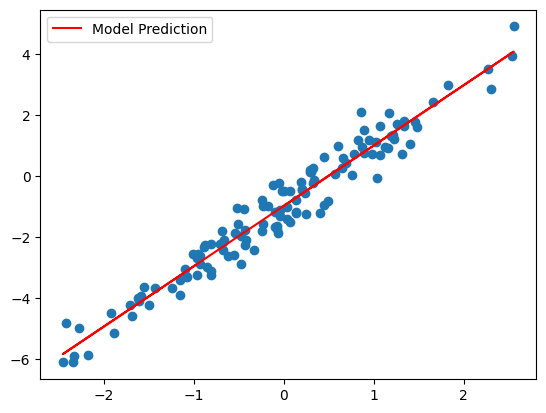

In [9]:
import matplotlib.pyplot as plt

params = jax.device_get(params)

plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
plt.legend();